## Goal... test training schemes
Test: Using $ W_{\mathrm{res}}\in\mathbb{R}^{N\times N} $ we take $ N $ steps before getting the loss $ \mathcal{L} $, on $ N+1 $ only, before backprop. This is motivated by work in Chaos paper indicating the memory is only as long as the rank of the controllability matrix $\mathbf{C}\in\mathbb{R}^{N\times NK}$. The max working memory contains info from the previous $N$ steps of the current time $t$. Alternatively, reservoir memory is $ t-N $ time-steps to predict the next step $ t+1 $.

In [10]:
import sys
sys.path.insert(1,'/home/bwhiteak/exESN/ESN_utils/')
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import ESN_util.rc_tools as rct
import ESN_util.rc_analysis as rca

from itertools import chain 
from torchviz import make_dot, make_dot_from_trace

import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
import pdb 
import time
from jupyterthemes import jtplot
jtplot.style()

def grad_printer(model: nn.Module) -> nn.Module:
    for parameter in model.parameters():
        parameter.register_hook(lambda grad: print(f'{grad}'))
    return model

In [11]:
DEV = 'cuda:6'
DTYPE = torch.float32 
#torch.set_num_interop_threads(4)
torch.set_num_threads(4)

In [12]:
K = 1
N = 30
L = 1
TRAIN = 14000
TEST = 1000

In [13]:
class Pmul(torch.autograd.Function):
    @staticmethod
    def forward(ctx, a, g):
        ctx.save_for_backward(a,g)
        return torch.mul(a,g)

    @staticmethod
    def backward(ctx, grad_output):
        a,g = ctx.saved_tensors
        da = grad_output*g 
        dg = grad_output*a
        return da, dg

class Clamp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return input.clamp(min=0, max=1) # the value in iterative = 2

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.clone()

class Leaky_Tanh(nn.Module):
    def __init__(self, N):
        """
        Initialize learnable parameters:
        alpha = controls influence of past information
        gamma = controls amplitude from nonlinear term
        """
        super(Leaky_Tanh,self).__init__()
        self.pmul = Pmul.apply
        self.clamp = Clamp.apply
        self.a = Parameter(torch.mul(torch.ones(1,N),.5))
        self.g = Parameter(torch.rand(1,N))
        
    def forward(self, xt, zt): 
        self.clamp(self.a)
        return (1-self.a)*xt + self.pmul(self.a,self.g)*torch.tanh(xt+zt) 
    
class SymESN(nn.Module):
    def __init__(self, k, n, l, r, rho):
        super(SymESN, self).__init__()

        self.N = n
        self.Q, self.d, self.Qt = self.initRes(r, rho)
        self.D = Parameter(self.d)
        self.Rin = nn.Linear(k, self.N, bias=False)
        self.Lky = Leaky_Tanh(self.N)
        self.Rout = nn.Linear(self.N+k,l, bias=False)

    def forward(self, hidden, ut):
        zt = self.Rin(ut)
        ht = torch.matmul(hidden,torch.matmul(self.Q, torch.matmul(torch.diag(self.D), self.Qt)))#self.Res(hidden)
        ht1 = self.Lky(ht,zt)
        out = self.Rout(torch.cat((ht1,ut),1))
        return ht1, out

    def packState(self, h=None):
        if(not h):
            h = torch.randn(1, self.N)
        else:
            h = h.detach_()
        return h
    def initRes(self, r, rho):
        A = torch.mul(torch.sub(torch.rand((self.N,self.N)),.5),2.)
        W = (A + torch.transpose(A,0,1))-torch.diag(torch.diagonal(A))
        eigmax = torch.max(torch.abs(torch.linalg.eigvals(W)))
        Wszd = torch.mul(torch.div(W,eigmax),rho)
        D,Q = torch.linalg.eig(Wszd)
        return torch.real(Q).cuda(DEV), torch.real(D).cuda(DEV), torch.real(torch.transpose(Q,0,1)).cuda(DEV)

esn = SymESN(K,N,L,1.0,.6).float().cuda(DEV)
print(esn)
for n,p in esn.named_parameters():
    print(n)

SymESN(
  (Rin): Linear(in_features=1, out_features=30, bias=False)
  (Lky): Leaky_Tanh()
  (Rout): Linear(in_features=31, out_features=1, bias=False)
)
D
Rin.weight
Lky.a
Lky.g
Rout.weight


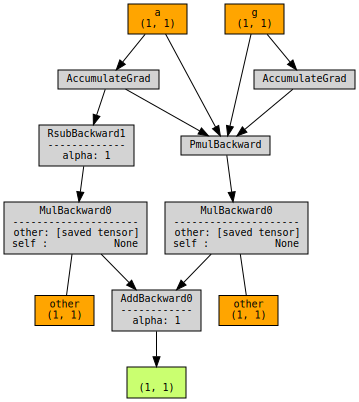

In [14]:
xt = torch.Tensor([[.1]])
ut = torch.Tensor([[.5]])
lky = Leaky_Tanh(1)
l = lky(xt,ut)

make_dot(l, params=dict(lky.named_parameters()), show_attrs=True, show_saved=True)

In [15]:
#make_dot(yhat, params=dict(esn.named_parameters()), show_attrs=True, show_saved=True)

In [16]:
FREERUN = 20
DT = .02
rho = 28.0
sigma = 10.0
beta = 8/3
BATCH = 10

def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

def  lorenz63(batch, length, delta=.02, x0_range=5):
    arrs = []
    for b in range(batch):
        state0 = np.array([1.,1.,1.])+np.random.randn(3)*x0_range
        t = np.arange(0,length,delta)
        states = odeint(f,state0,t)
        muX = np.mean(states[:], axis=0)
        arrs.append((states-muX).T)
    return np.array(arrs)

#(batch,dim,data_len)
#signal = torch.tensor(states[:TRAIN,0]-muX, device=DEV).float()
        
X = lorenz63(BATCH, 300+FREERUN, .02, x0_range=1.0)
targets = torch.tensor(X[:,0,:],  device=DEV).float()

#state0 = [1.,1.,1.]
#t = np.arange(0,300+FREERUN,DT)
#states = odeint(f,state0,t)
#muX = np.mean(states[:,0])
#signal = torch.tensor(states[:TRAIN,0]-muX, device=DEV).float()

In [17]:
criterion = nn.MSELoss()
optimizer = optim.Adam(esn.parameters(),lr=.001)

In [18]:
EPOCHS = 3
alphas = np.zeros((EPOCHS*BATCH,N))
gammas = np.zeros((EPOCHS*BATCH,N))
Agrad = np.zeros((EPOCHS*BATCH,N))
Ggrad = np.zeros((EPOCHS*BATCH,N))
SRgrad = np.zeros((EPOCHS*BATCH,N))
eigs = np.zeros((EPOCHS*BATCH,N))
epoch_loss = np.zeros(EPOCHS*BATCH)
torch.autograd.set_detect_anomaly(True)
for s in range(BATCH):
    signal = targets[s,:TRAIN]
    start = time.time()
    for ep in range(EPOCHS):
        print(f'Epoch: {ep} Batch: {s}  {ep+(s*ep)}')
        preds = np.zeros(TRAIN)
        xt = esn.packState().cuda(DEV)
        running_loss = 0.
        loss = 0.
        for i in range(TRAIN-N):
            y = signal[i+N].view(1,1)
            optimizer.zero_grad()
            for j in range(i,i+N):  # Go N steps and make the i+N+1 prediction
                ut = signal[j].view(1,1)  # Next forcing
                xt1, yhat = esn(xt,ut)
                xt = xt1  # Feedback state
            loss = criterion(yhat,y)  # Backprop from last pred only
            preds[i+N] = yhat.detach().cpu().numpy()[0,0] # Preds should start at N going to TRAIN
            running_loss += loss.item()
            loss.backward(retain_graph=False)
            if(i==TRAIN-N-1):
                Agrad[(s*EPOCHS)+ep] = esn.Lky.a.grad[0,:].cpu().detach().numpy() 
                Ggrad[(s*EPOCHS)+ep] = esn.Lky.g.grad[0,:].cpu().detach().numpy()  
                SRgrad[(s*EPOCHS)+ep] = esn.D.grad[:].cpu().detach().numpy()  
            optimizer.step()
            xt = esn.packState().cuda(DEV)
        eigs[(s*EPOCHS)+ep] = esn.D.data[:].cpu().detach().numpy()   # Value of D
        alphas[(s*EPOCHS)+ep] = esn.Lky.a.data[:].cpu().detach().numpy() 
        gammas[(s*EPOCHS)+ep] = esn.Lky.g.data[:].cpu().detach().numpy()  
        epoch_loss[(s*EPOCHS)+ep] = running_loss/(TRAIN-N)
        print(epoch_loss[ep])
        if(ep%(EPOCHS-1)==0):
            print(f'Epoch: {ep}')
            target = signal.detach().cpu().numpy()
            plt.figure(figsize=(15,16))
            ax1 = plt.subplot(421)
            ax1.set_title('Target and Predictions')
            ax1.plot(target, label='tar')
            ax1.plot(preds, label='pred')
            ax1.set_ylim(-25,25)
            

            ax2 = plt.subplot(422)
            ax2.set_title('Eigenvalues in D')
            for i in range(eigs.shape[1]):
                ax2.plot(eigs[:,i],label=f'eig{i}')
            ax2.set_ylim(-2,2)
            

            ax3 = plt.subplot(423)
            ax3.set_title('Value of Alpha')
            for i in range(alphas.shape[1]):
                ax3.plot(alphas[:,i], label=f'alpha{i}')
            ax3.set_ylim(-3,3)
            

            ax4 = plt.subplot(424)
            ax4.set_title('Value of Gamma')
            for i in range(gammas.shape[1]):
                ax4.plot(gammas [:,i], label=f'gamma{i}')
            ax4.set_ylim(-3,3)
            

            ax5 = plt.subplot(425)
            ax5.set_title('Alpha Gradients')
            for i in range(Agrad.shape[1]):
                ax5.plot(Agrad[:,i], label=f'A{i}')
            ax5.set_ylim(-2,2)
            

            ax6 = plt.subplot(426)
            ax6.set_title('Gamma Gradients')
            for i in range(Ggrad.shape[1]):
                ax6.plot(Ggrad[:,i], label=f'G{i}')
            ax6.set_ylim(-1,1)
            


            ax7 = plt.subplot(427)
            ax7.set_title('Gradients of Diagonal Matrix')
            for i in range(SRgrad.shape[1]):
                ax7.plot(SRgrad[:,i], label=f'SR{i}')
            ax7.set_ylim(-5,5)
            

            ax8 = plt.subplot(428)
            ax8.set_title('Ave Loss Per Epoch')
            ax8.plot(epoch_loss, label=f'ave loss')
            plt.tight_layout()
            plt.show()
            plt.close()
    print(f'Time to run epoch: {time.time()-start}  Target data {s}')

Epoch: 0 Batch: 0  0
0.8718099285475363


ZeroDivisionError: integer division or modulo by zero

In [ ]:
plt.figure(figsize=(15,12))
ax1 = plt.subplot(421)
ax1.set_title('Target and Predictions')
ax1.plot(target, label='tar')
ax1.plot(preds, label='pred')
ax1.set_ylim(-25,25)


ax2 = plt.subplot(422)
ax2.set_title('Eigenvalues in D')
for i in range(eigs.shape[1]):
    ax2.plot(eigs[:,i],label=f'eig{i}')
ax2.set_ylim(-2,2)


ax3 = plt.subplot(423)
ax3.set_title('Value of Alpha')
for i in range(alphas.shape[1]):
    ax3.plot(alphas[:,i], label=f'alpha{i}')
ax3.set_ylim(-3,3)


ax4 = plt.subplot(424)
ax4.set_title('Value of Gamma')
for i in range(gammas.shape[1]):
    ax4.plot(gammas [:,i], label=f'gamma{i}')
ax4.set_ylim(-3,3)


ax5 = plt.subplot(425)
ax5.set_title('Alpha Gradients')
for i in range(Agrad.shape[1]):
    ax5.plot(Agrad[:,i], label=f'A{i}')
ax5.set_ylim(-2,2)


ax6 = plt.subplot(426)
ax6.set_title('Gamma Gradients')
for i in range(Ggrad.shape[1]):
    ax6.plot(Ggrad[:,i], label=f'G{i}')
ax6.set_ylim(-1,1)



ax7 = plt.subplot(427)
ax7.set_title('Gradients of Diagonal Matrix')
for i in range(SRgrad.shape[1]):
    ax7.plot(SRgrad[:,i], label=f'SR{i}')
ax7.set_ylim(-5,5)


ax8 = plt.subplot(428)
ax8.set_title('Ave Loss Per Epoch')
ax8.plot(epoch_loss, label=f'ave loss')
plt.tight_layout()
plt.show()
plt.close()

In [28]:
# Make predictions
# Scheme: Freeze model
# Use a target signal -> random init state -> warm-up through training data -> ...
# -> switch to free-run prediction on test. targets is size (10,16000)
preds = torch.zeros((BATCH,TRAIN+TEST), device=DEV)  # Store all predictions for batches
esn.eval()
with torch.no_grad():
    for t in range(2):
        print(f'Signal {t}')
        xt = esn.packState().cuda(DEV)  # Get an initial state
        signal = targets[t,:]  # Select signal from numpy array of signals
        for i in range(TRAIN-N):
            if(i%10==0):
                print(f'Training {i}')
            y = signal[i+N].view(1,1)
            for j in range(i,i+N):  # Go N steps and make the i+N+1 prediction
                ut = signal[j].view(1,1)  # Next forcing
                xt1, yhat = esn(xt,ut)
                xt = xt1  # Feedback state
            preds[t,i] = yhat[0,0]
        for i in range(TRAIN-N,TRAIN+TEST-N): # Switch to free-run predictions
            if(i%10==0):
                print(f'Testing {i}')
            for j in range(i,i+N):
                ut = yhat
                xt1, yhat = esn(xt,ut)
                xt = xt1  # Feedback state
                print(f'{yhat[0,0]}')
            preds[t,i] = yhat[0,0]

Signal 0
Training 0
Training 10
Training 20
Training 30
Training 40
Training 50
Training 60
Training 70
Training 80
Training 90
Training 100
Training 110
Training 120
Training 130
Training 140
Training 150
Training 160
Training 170
Training 180
Training 190
Training 200
Training 210
Training 220
Training 230
Training 240
Training 250
Training 260
Training 270
Training 280
Training 290
Training 300
Training 310
Training 320
Training 330
Training 340
Training 350
Training 360
Training 370
Training 380
Training 390
Training 400
Training 410
Training 420
Training 430
Training 440
Training 450
Training 460
Training 470
Training 480
Training 490
Training 500
Training 510
Training 520
Training 530
Training 540
Training 550
Training 560
Training 570
Training 580
Training 590
Training 600
Training 610
Training 620
Training 630
Training 640
Training 650
Training 660
Training 670
Training 680
Training 690
Training 700
Training 710
Training 720
Training 730
Training 740
Training 750
Training 760
T

Training 5940
Training 5950
Training 5960
Training 5970
Training 5980
Training 5990
Training 6000
Training 6010
Training 6020
Training 6030
Training 6040
Training 6050
Training 6060
Training 6070
Training 6080
Training 6090
Training 6100
Training 6110
Training 6120
Training 6130
Training 6140
Training 6150
Training 6160
Training 6170
Training 6180
Training 6190
Training 6200
Training 6210
Training 6220
Training 6230
Training 6240
Training 6250
Training 6260
Training 6270
Training 6280
Training 6290
Training 6300
Training 6310
Training 6320
Training 6330
Training 6340
Training 6350
Training 6360
Training 6370
Training 6380
Training 6390
Training 6400
Training 6410
Training 6420
Training 6430
Training 6440
Training 6450
Training 6460
Training 6470
Training 6480
Training 6490
Training 6500
Training 6510
Training 6520
Training 6530
Training 6540
Training 6550
Training 6560
Training 6570
Training 6580
Training 6590
Training 6600
Training 6610
Training 6620
Training 6630
Training 6640
Traini

Training 11680
Training 11690
Training 11700
Training 11710
Training 11720
Training 11730
Training 11740
Training 11750
Training 11760
Training 11770
Training 11780
Training 11790
Training 11800
Training 11810
Training 11820
Training 11830
Training 11840
Training 11850
Training 11860
Training 11870
Training 11880
Training 11890
Training 11900
Training 11910
Training 11920
Training 11930
Training 11940
Training 11950
Training 11960
Training 11970
Training 11980
Training 11990
Training 12000
Training 12010
Training 12020
Training 12030
Training 12040
Training 12050
Training 12060
Training 12070
Training 12080
Training 12090
Training 12100
Training 12110
Training 12120
Training 12130
Training 12140
Training 12150
Training 12160
Training 12170
Training 12180
Training 12190
Training 12200
Training 12210
Training 12220
Training 12230
Training 12240
Training 12250
Training 12260
Training 12270
Training 12280
Training 12290
Training 12300
Training 12310
Training 12320
Training 12330
Training 1

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14020
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14090
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14160
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14230
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14300
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14370
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14440
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14510
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14580
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14650
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14720
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14790
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14860
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14930
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

Training 2420
Training 2430
Training 2440
Training 2450
Training 2460
Training 2470
Training 2480
Training 2490
Training 2500
Training 2510
Training 2520
Training 2530
Training 2540
Training 2550
Training 2560
Training 2570
Training 2580
Training 2590
Training 2600
Training 2610
Training 2620
Training 2630
Training 2640
Training 2650
Training 2660
Training 2670
Training 2680
Training 2690
Training 2700
Training 2710
Training 2720
Training 2730
Training 2740
Training 2750
Training 2760
Training 2770
Training 2780
Training 2790
Training 2800
Training 2810
Training 2820
Training 2830
Training 2840
Training 2850
Training 2860
Training 2870
Training 2880
Training 2890
Training 2900
Training 2910
Training 2920
Training 2930
Training 2940
Training 2950
Training 2960
Training 2970
Training 2980
Training 2990
Training 3000
Training 3010
Training 3020
Training 3030
Training 3040
Training 3050
Training 3060
Training 3070
Training 3080
Training 3090
Training 3100
Training 3110
Training 3120
Traini

Training 8280
Training 8290
Training 8300
Training 8310
Training 8320
Training 8330
Training 8340
Training 8350
Training 8360
Training 8370
Training 8380
Training 8390
Training 8400
Training 8410
Training 8420
Training 8430
Training 8440
Training 8450
Training 8460
Training 8470
Training 8480
Training 8490
Training 8500
Training 8510
Training 8520
Training 8530
Training 8540
Training 8550
Training 8560
Training 8570
Training 8580
Training 8590
Training 8600
Training 8610
Training 8620
Training 8630
Training 8640
Training 8650
Training 8660
Training 8670
Training 8680
Training 8690
Training 8700
Training 8710
Training 8720
Training 8730
Training 8740
Training 8750
Training 8760
Training 8770
Training 8780
Training 8790
Training 8800
Training 8810
Training 8820
Training 8830
Training 8840
Training 8850
Training 8860
Training 8870
Training 8880
Training 8890
Training 8900
Training 8910
Training 8920
Training 8930
Training 8940
Training 8950
Training 8960
Training 8970
Training 8980
Traini

Training 13860
Training 13870
Training 13880
Training 13890
Training 13900
Training 13910
Training 13920
Training 13930
Training 13940
Training 13950
Training 13960
Testing 13970
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14330
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14400
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14470
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14540
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14610
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14680
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14750
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14820
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14890
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Testing 14960
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

In [31]:
predictions = preds.detach().cpu().numpy()
truth = X[:,0,:]

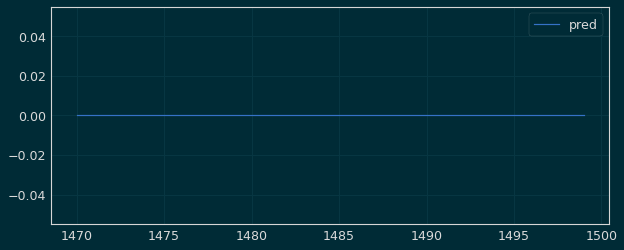

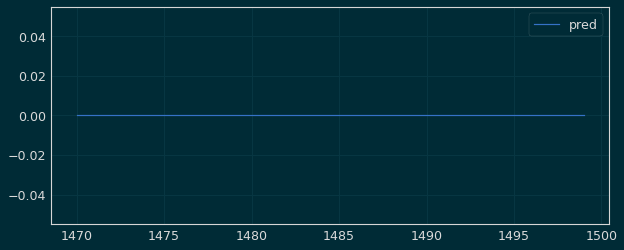

In [32]:
for t in range(2):
    plt.figure(figsize=(10,4))
    plt.plot(predictions[t,13500:15000], label='pred')
    #plt.plot(truth[t,13500:15000], label='truth')
    plt.legend()
    plt.show()

In [33]:
torch.save({'model' : esn.state_dict(),
            'optimizer' : optimizer.state_dict(), 
            'Qmat' : esn.Q},
           './Data/SavedModels/model_AD3.pt')


esn_dict = torch.load('./Data/SavedModels/model_AD3.pt')
esn.load_state_dict(esn_dict['model'])

<All keys matched successfully>

In [34]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in esn.state_dict():
    print(param_tensor, "\t", esn.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
D 	 torch.Size([30])
Rin.weight 	 torch.Size([30, 1])
Lky.a 	 torch.Size([1, 30])
Lky.g 	 torch.Size([1, 30])
Rout.weight 	 torch.Size([1, 31])
Optimizer's state_dict:
state 	 {0: {'step': 13970, 'exp_avg': tensor([ 0.0088,  0.0295, -0.0125,  0.0031, -0.0019,  0.0008,  0.0063,  0.0105,
         0.0010, -0.0004,  0.0036,  0.0006, -0.0063,  0.0014,  0.0064, -0.0025,
         0.0022,  0.0005,  0.0023,  0.0083,  0.0046,  0.0101, -0.0236,  0.0018,
         0.0042,  0.0064, -0.0036, -0.0023,  0.0002,  0.0009], device='cuda:6'), 'exp_avg_sq': tensor([5.1297e-01, 2.0509e-01, 5.9268e+00, 2.7786e+00, 1.2508e-02, 1.0724e-02,
        7.2832e-02, 1.2967e+00, 3.4655e-02, 1.1089e-03, 5.4433e-02, 1.4109e-01,
        8.3047e-03, 1.5336e-02, 3.0551e-02, 6.3247e-03, 1.9777e-02, 8.0860e-04,
        1.6947e-02, 9.1825e-02, 2.6028e-03, 1.0779e-01, 3.1811e-01, 5.5344e-03,
        5.3135e-02, 5.4472e-03, 1.5311e-02, 1.1343e-01, 2.9687e-03, 9.3630e-03],
       device='cuda:6')}, 1: {'step':

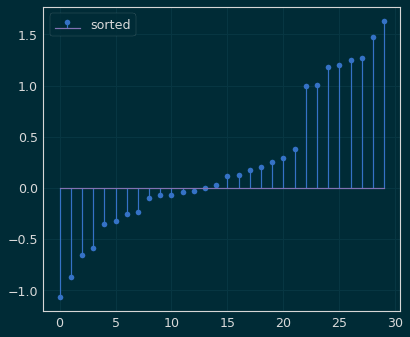

Sum of eignvals 6.8931756019592285


In [48]:
eigenvalues = esn_dict['model']['D'].cpu().numpy()
eigsorted = np.argsort(eigenvalues)
plt.stem(eigenvalues[eigsorted], label='sorted')
plt.legend()
plt.show()

print(f'Sum of eignvals {np.sum(eigenvalues)}')

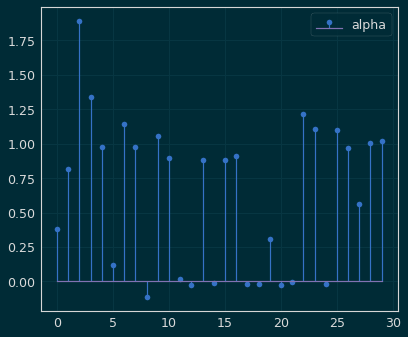

In [36]:
Alphas = esn_dict['model']['Lky.a'].detach().cpu().numpy()
plt.stem(np.squeeze(Alphas), label='alpha')
plt.legend()
plt.show()

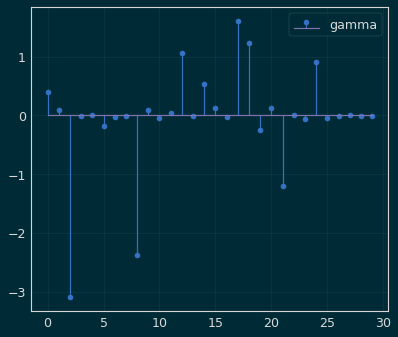

In [37]:
Gammas = esn_dict['model']['Lky.g'].detach().cpu().numpy()
plt.stem(np.squeeze(Gammas), label='gamma')
plt.legend()
plt.show()

In [38]:
D = np.diag(eigenvalues)
Q = esn_dict['Qmat'].detach().cpu().numpy()
Qt = np.transpose(Q)
Wr = np.dot(Q,np.dot(D,Qt))

In [39]:
Wi = esn_dict['model']['Rin.weight'].detach().cpu().numpy()
A = rca.leaky_jacobian(np.zeros((N,K)), np.zeros((K,K)), Alphas.T, Gammas.T, Wi, Wr)
B = rca.partial_u(np.zeros((N,K)), np.zeros((K,K)), Alphas.T, Gammas.T, Wi, Wr)
Cn = rca.reachable_matrix(A,B)
Cn = Cn/np.max(np.abs(rca.eig_spectrum(Cn)))

In [40]:
def rank_curve(Mat, tols):
    return rca.rank(Mat,tols) 

def rank_max_grad(curve):
    return np.argmax(np.gradient(curve))

tolerances = [1/10**x for x in range(0,20)]
ranks = rank_curve(Cn,tolerances)
idx = rank_max_grad(ranks)
print(f'Ave rank for largest gradient {(ranks[idx]+ranks[idx])/2}')

Ave rank for largest gradient 22.0


In [ ]:
Q = esn_dict['Qmat']
Q = Q.detach().cpu().numpy()
D = np.diag(eigenvalues)
Wr = np.dot(Q, np.dot(D,Q.T))

In [ ]:
plt.figure()
for i in range(Wr.shape[0]):
    plt.plot(Q[:,i])
plt.show()
plt.close()

In [ ]:
predictions[0,14500]

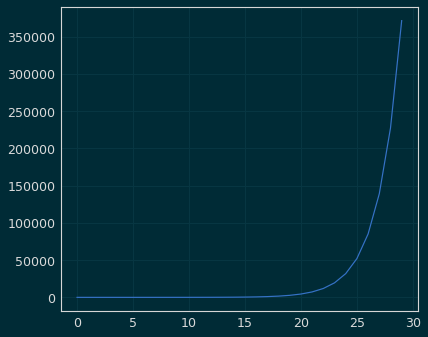

In [50]:
impulse = np.zeros(N).reshape(N,1)
impulse[0,0] = 1.

hold = []
for i in range(30):
    impulse = np.dot(Wr,impulse)
    hold.append(np.linalg.norm(impulse))
    
plt.plot(hold)
plt.show()

In [44]:
np.max(np.abs(rca.eig_spectrum(A)))

1.95623637356722

6.8931756